<a href="https://colab.research.google.com/github/pachterlab/COVID-19-testing-database/blob/master/notebooks/basic_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pachterlab/COVID-19-testing-database.git

Cloning into 'COVID-19-testing-database'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 63 (delta 13), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [74]:
!wget --output-file="logs.csv" "https://docs.google.com/spreadsheets/d/10I8bVkLzvrmXJsb5N-8JSFpWw5vBwDKYzyOVAI4viKo/export?format=csv&gid=1514440859" -O "sheet.csv"

In [77]:
!awk 'NR>4' sheet.csv > data.csv

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [78]:
df = pd.read_csv("data.csv")
df.index = df.institution.values
top_states = df.groupby("state").count().institution.sort_values(ascending=False).head(5).index.values


In [6]:
top_states

array(['CA', 'NY', 'PA', 'TX', 'MA'], dtype=object)

# Basic stats

In [7]:
df.testing.value_counts()/df.testing.value_counts().sum()*100

TRUE       53.952569
FALSE      37.351779
Unknown     8.695652
Name: testing, dtype: float64

In [8]:
df.test_initial.value_counts()/df.test_initial.value_counts().sum()*100

FALSE      62.252964
TRUE       26.877470
Unknown    10.869565
Name: test_initial, dtype: float64

In [9]:
df.test_recurring.value_counts()/df.test_recurring.value_counts().sum()*100

FALSE      65.544554
TRUE       19.801980
Unknown    14.653465
Name: test_recurring, dtype: float64

In [10]:
df.test_vendor.value_counts().sort_values(ascending=False)

Broad Institute               21
Student Health                 5
Quest                          4
Vault Health                   3
Student Health Services        2
                              ..
Testing Centers of America     1
ConvenientMD and Quest         1
IUP Health Service             1
Conway Regional Health         1
Cayuga Health                  1
Name: test_vendor, Length: 104, dtype: int64

In [11]:
# confusion matrix, testing initial vs testing recurring
v = df.groupby(['test_initial', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v/v.values.sum()*100

test_recurring,FALSE,TRUE,Unknown
test_initial,,,
FALSE,59.126984,1.984127,1.388889
TRUE,5.952381,17.063492,3.769841
Unknown,0.595238,0.595238,9.523810


In [12]:
# Testing based on school type
v = df.groupby(['school_type', 'testing']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v/v.values.sum(axis=1)[:,None]*100

testing,FALSE,TRUE,Unknown
school_type,,,
Public,43.037975,51.054852,5.907173
Private,32.342007,56.505576,11.152416


In [13]:
v = df.groupby(['rtc_model', 'testing']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)

v/v.values.sum(axis=1)[:,None]*100

testing,FALSE,TRUE,Unknown
rtc_model,,,
Planning for in-person,44.890511,47.810219,7.299270
Proposing a hybrid model,23.497268,67.213115,9.289617
Planning for online,52.500000,32.500000,15.000000
Considering a range of scenarios,25.000000,50.000000,25.000000
Planning for fully and partially online,100.000000,0.000000,0.000000
"All classes online, but many students will live on campus",0.000000,100.000000,0.000000
Proposing a hybrid model (all students on campus),0.000000,100.000000,0.000000


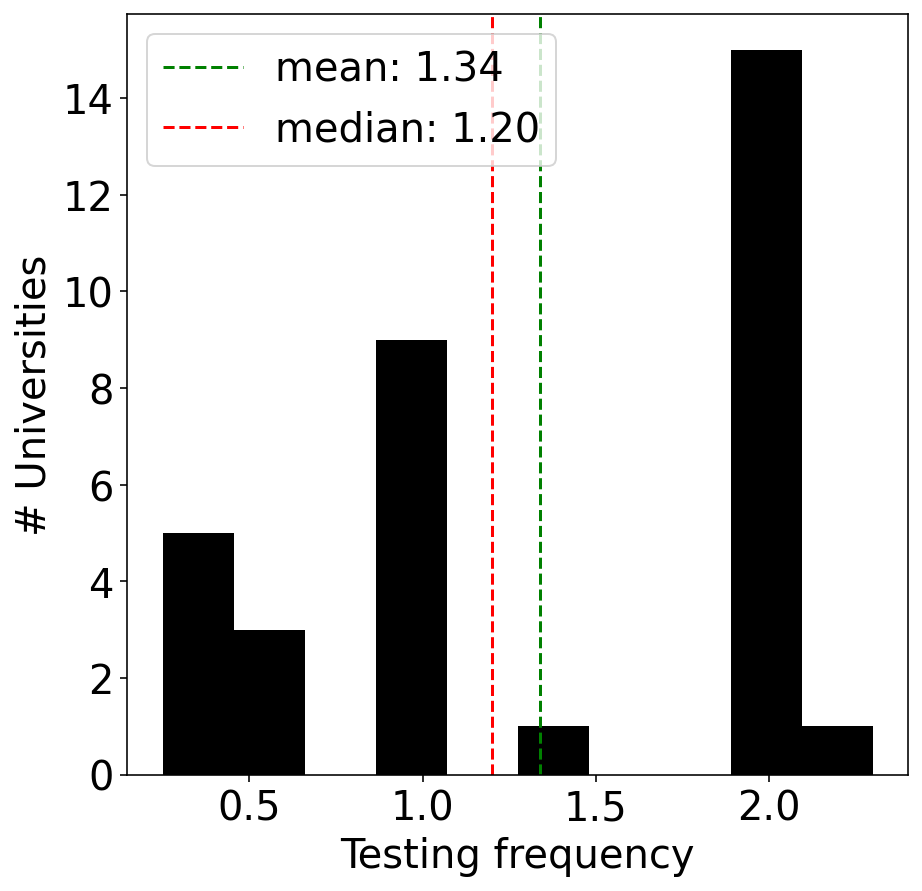

In [42]:
fig, ax = plt.subplots(figsize=(7,7))
x = df[df.test_freq.notna()].query("test_freq>0").test_freq.values

mean = x.mean()
median = np.median(x)
ax.hist(x, color="k")
ax.axvline(mean, label=f"mean: {mean:,.2f}", color="green", linestyle="--")
ax.axvline(median, label=f"median: {median:,.2f}", color="red", linestyle="--")
kwd = {
    "xlabel": "Testing frequency",
    "ylabel": "# Universities"
}
ax.set(**kwd)
ax.legend()

fig.show()

# Top 5 states by number of universities

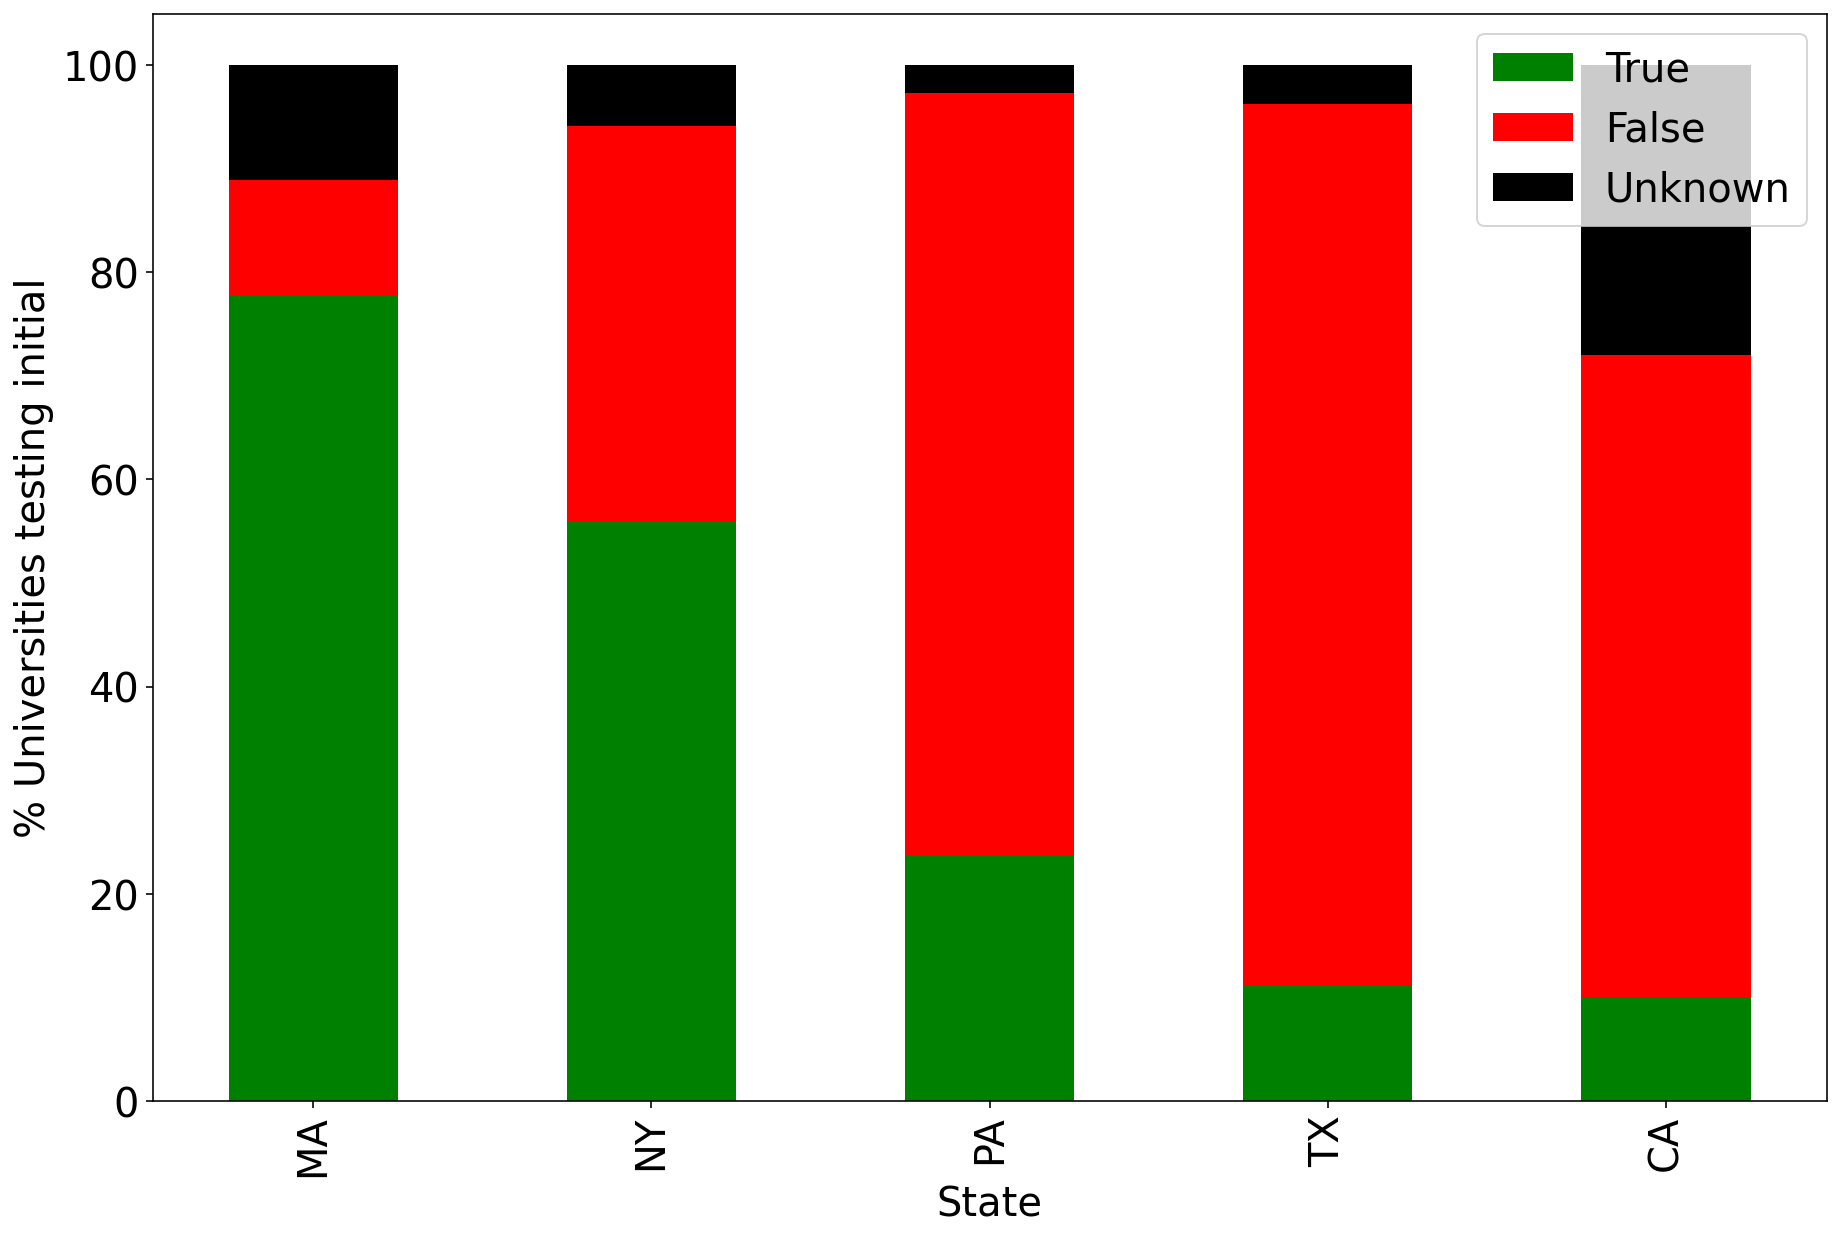

In [43]:
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
vp = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(15,10))

vp  = vp.loc[top_states].sort_values(by="TRUE", ascending=False)
ind = np.arange(vp.shape[0])    # the x locations for the groups
labels = vp.index.values


x = vp.TRUE.values
y = vp.FALSE.values
z = vp.Unknown.values
width = 0.5     # the width of the bars: can also be len(x) sequence

ax.bar(ind, x, width,label="True", color="green")
ax.bar(ind, y, width, bottom=x, label="False", color="red")
ax.bar(ind, z, width, bottom=x+y, label="Unknown", color="black")

kwd = {
    "xticks" : ind,
    "xticklabels": labels,
    "xlabel": "State",
    "ylabel": "% Universities testing initial"
}
ax.set(**kwd)
ax.set_xticklabels(labels, rotation=90)
ax.legend()


fig.show()

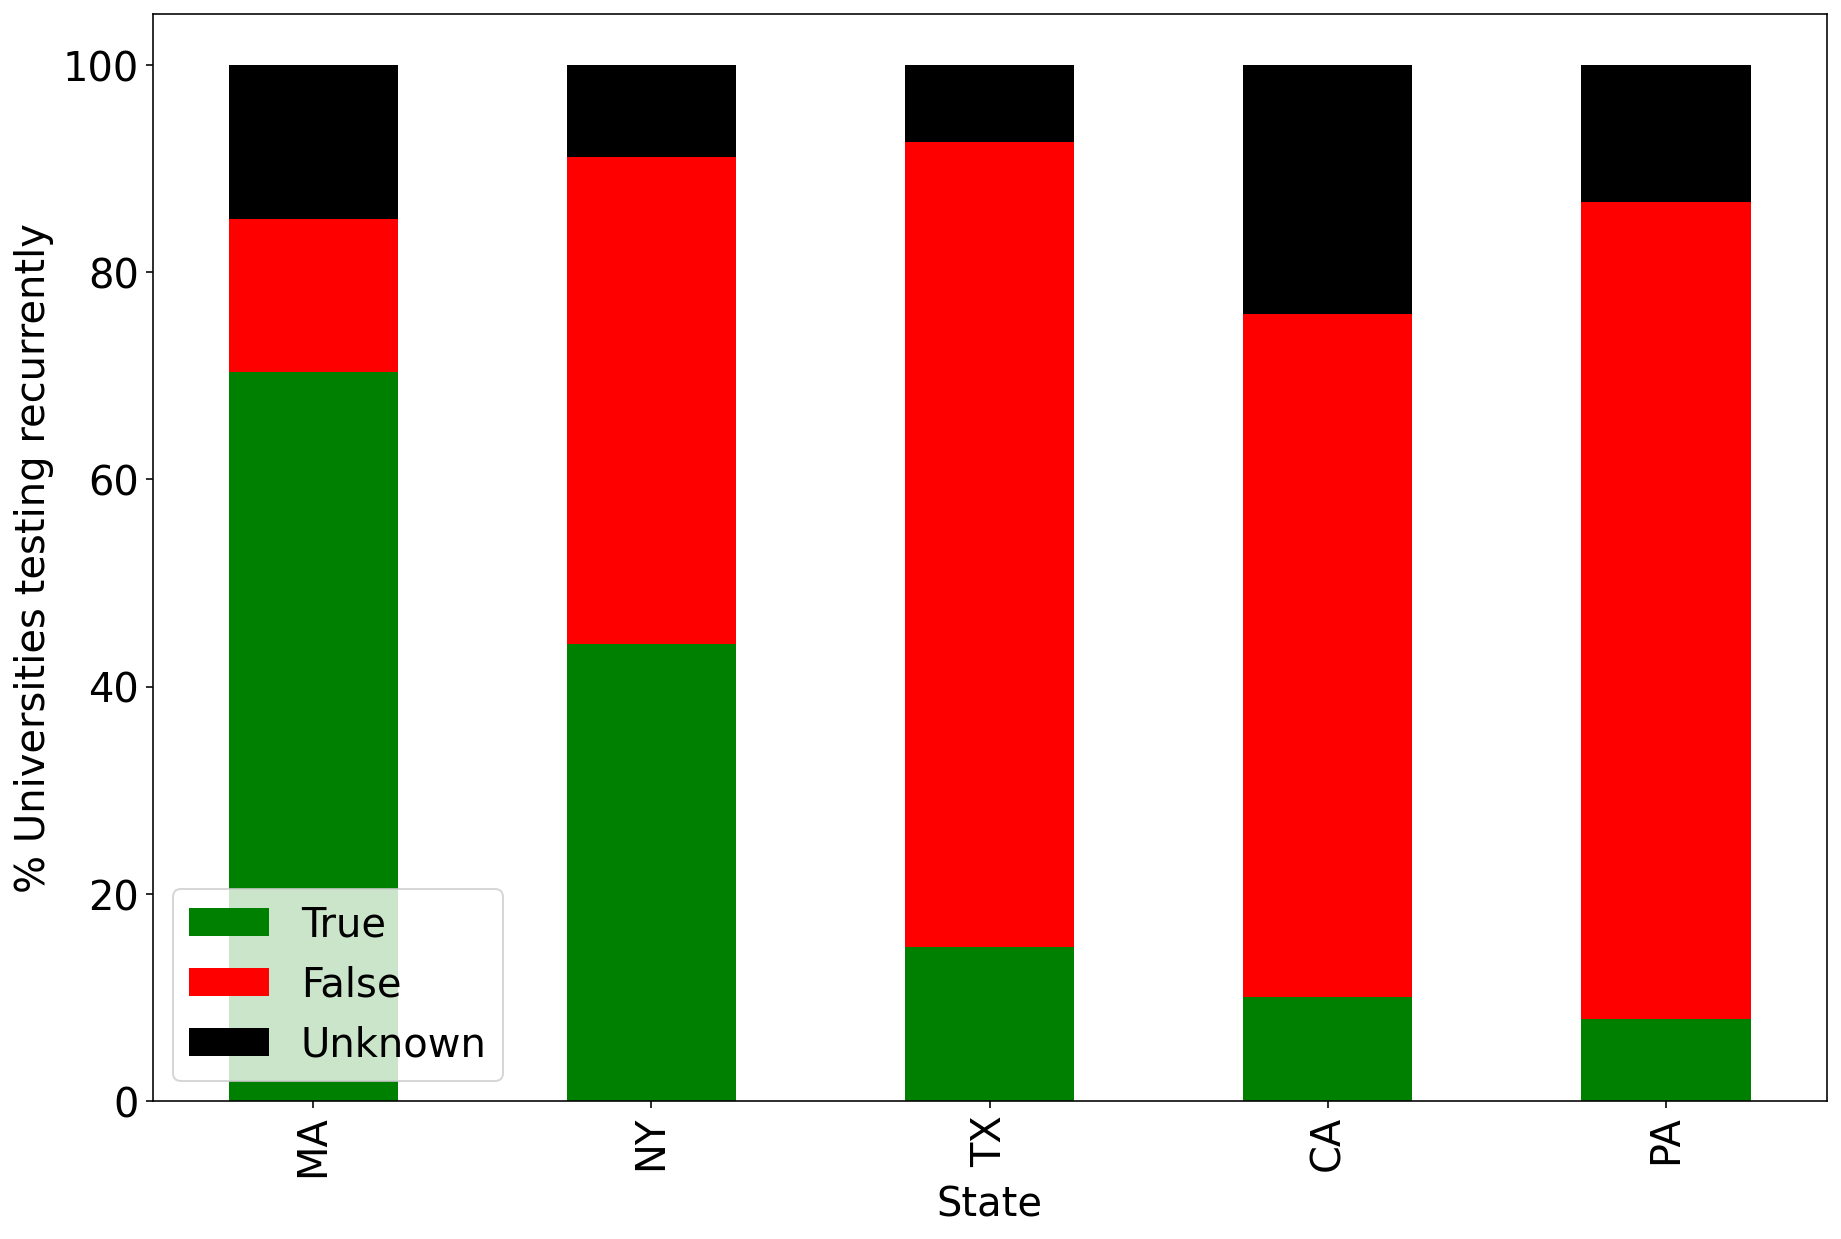

In [44]:
v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
vp = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(15,10))

vp  = vp.loc[top_states].sort_values(by="TRUE", ascending=False)
ind = np.arange(vp.shape[0])    # the x locations for the groups
labels = vp.index.values


x = vp.TRUE.values
y = vp.FALSE.values
z = vp.Unknown.values

width = 0.5     # the width of the bars: can also be len(x) sequence

ax.bar(ind, x, width,label="True", color="green")
ax.bar(ind, y, width, bottom=x, label="False", color="red")
ax.bar(ind, z, width, bottom=x+y, label="Unknown", color="black")

kwd = {
    "xticks" : ind,
    "xticklabels": labels,
    "xlabel": "State",
    "ylabel": "% Universities testing recurrently"
}
ax.set(**kwd)
ax.set_xticklabels(labels, rotation=90)
ax.legend()


fig.show()

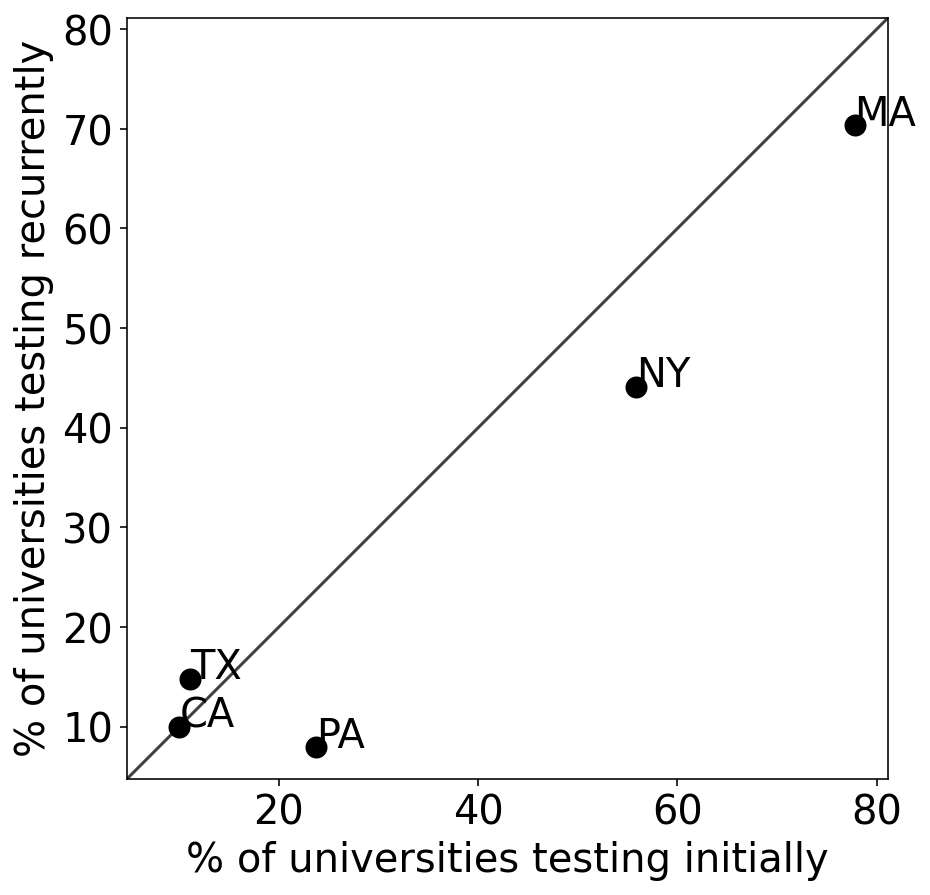

In [45]:
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
initial = v/v.values.sum(axis=1)[:,None]*100

v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
recurrent = v/v.values.sum(axis=1)[:,None]*100

initial = initial.loc[top_states]
recurrent = recurrent.loc[top_states]

fig, ax = plt.subplots(figsize=(7,7))

x = initial.TRUE.values
y = recurrent.TRUE.values

ax.scatter(x, y, s=100, color="k")
yex(ax)
for (xx, yy, txt) in zip(x, y, top_states):
  ax.annotate(txt, (xx, yy))

kwd = {
    "xlabel": "% of universities testing initially",
    "ylabel": "% of universities testing recurrently"
}
ax.set(**kwd)

fig.show()

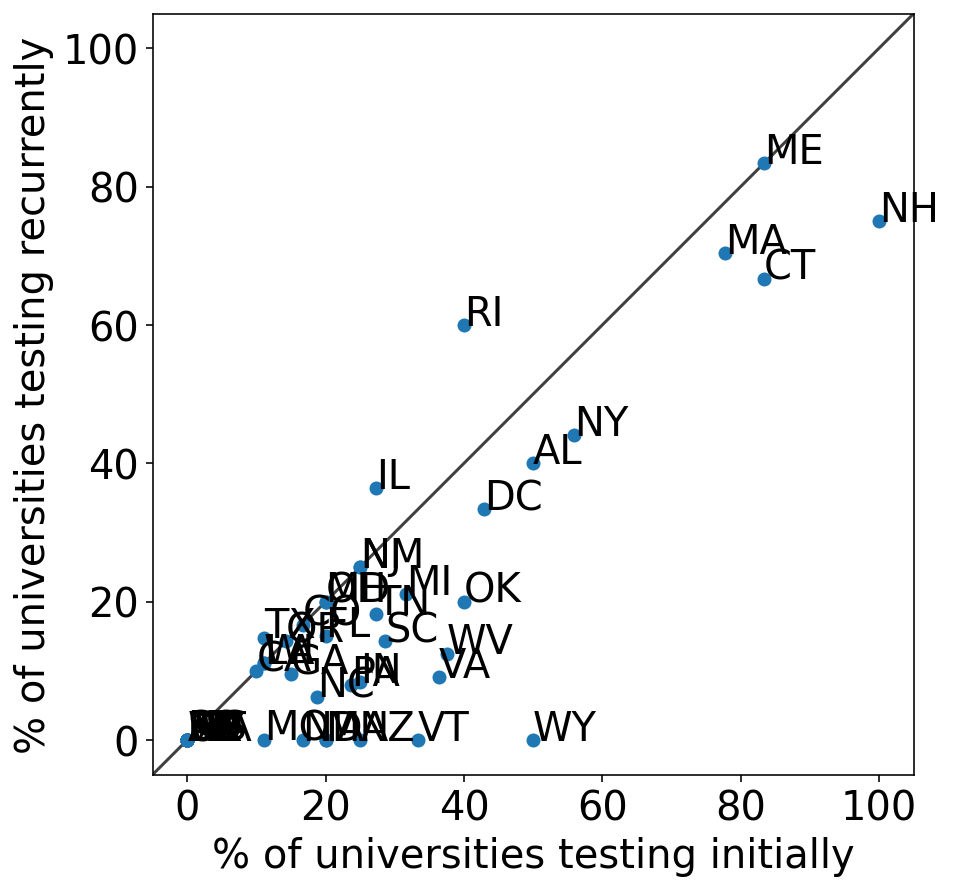

In [46]:
# all states
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0)
initial = v/v.values.sum(axis=1)[:,None]*100

v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0)
recurrent = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(7,7))


x = initial.TRUE.values
y = recurrent.TRUE.values

ax.scatter(x, y)
yex(ax)

kwd = {
    "xlabel": "% of universities testing initially",
    "ylabel": "% of universities testing recurrently"
}
ax.set(**kwd)
for (xx, yy, txt) in zip(x, y, initial.index.values):
  ax.annotate(txt, (xx, yy))
fig.show()

# Positivity rate per state

In [47]:
!git clone https://github.com/CSSEGISandData/COVID-19.git

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [48]:
old = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/07-26-2020.csv")
daily = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/08-02-2020.csv")

In [49]:
s2a = {
    "Alabama" : "AL",
"Alaska" : "AK",
"Arizona" : "AZ",
"Arkansas" : "AR",
"California" : "CA",
"Colorado" : "CO",
"Connecticut" : "CT",
"Delaware" : "DE",
"Florida" : "FL",
"Georgia" : "GA",
"Hawaii" : "HI",
"Idaho" : "ID",
"Illinois" : "IL",
"Indiana" : "IN",
"Iowa" : "IA",
"Kansas" : "KS",
"Kentucky" : "KY",
"Louisiana" : "LA",
"Maine" : "ME",
"Maryland" : "MD",
"Massachusetts" : "MA",
"Michigan" : "MI",
"Minnesota" : "MN",
"Mississippi" : "MS",
"Missouri" : "MO",
"Montana" : "MT",
"Nebraska" : "NE",
"Nevada" : "NV",
"New Hampshire" : "NH",
"New Jersey" : "NJ",
"New Mexico" : "NM",
"New York" : "NY",
"North Carolina" : "NC",
"North Dakota" : "ND",
"Ohio" : "OH",
"Oklahoma" : "OK",
"Oregon" : "OR",
"Pennsylvania" : "PA",
"Rhode Island" : "RI",
"South Carolina" : "SC",
"South Dakota" : "SD",
"Tennessee" : "TN",
"Texas" : "TX",
"Utah" : "UT",
"Vermont" : "VT",
"Virginia" : "VA",
"Washington" : "WA",
"West Virginia" : "WV",
"Wisconsin" : "WI",
"Wyoming" : "WY"
}

In [50]:
daily.index = daily.Province_State.apply(lambda x: s2a.get(x, x))
old.index = old.Province_State.apply(lambda x: s2a.get(x, x))

In [51]:
pos = (daily.loc[top_states]["Confirmed"]-old.loc[top_states]["Confirmed"])/(daily.loc[top_states]["People_Tested"]-old.loc[top_states]["People_Tested"])

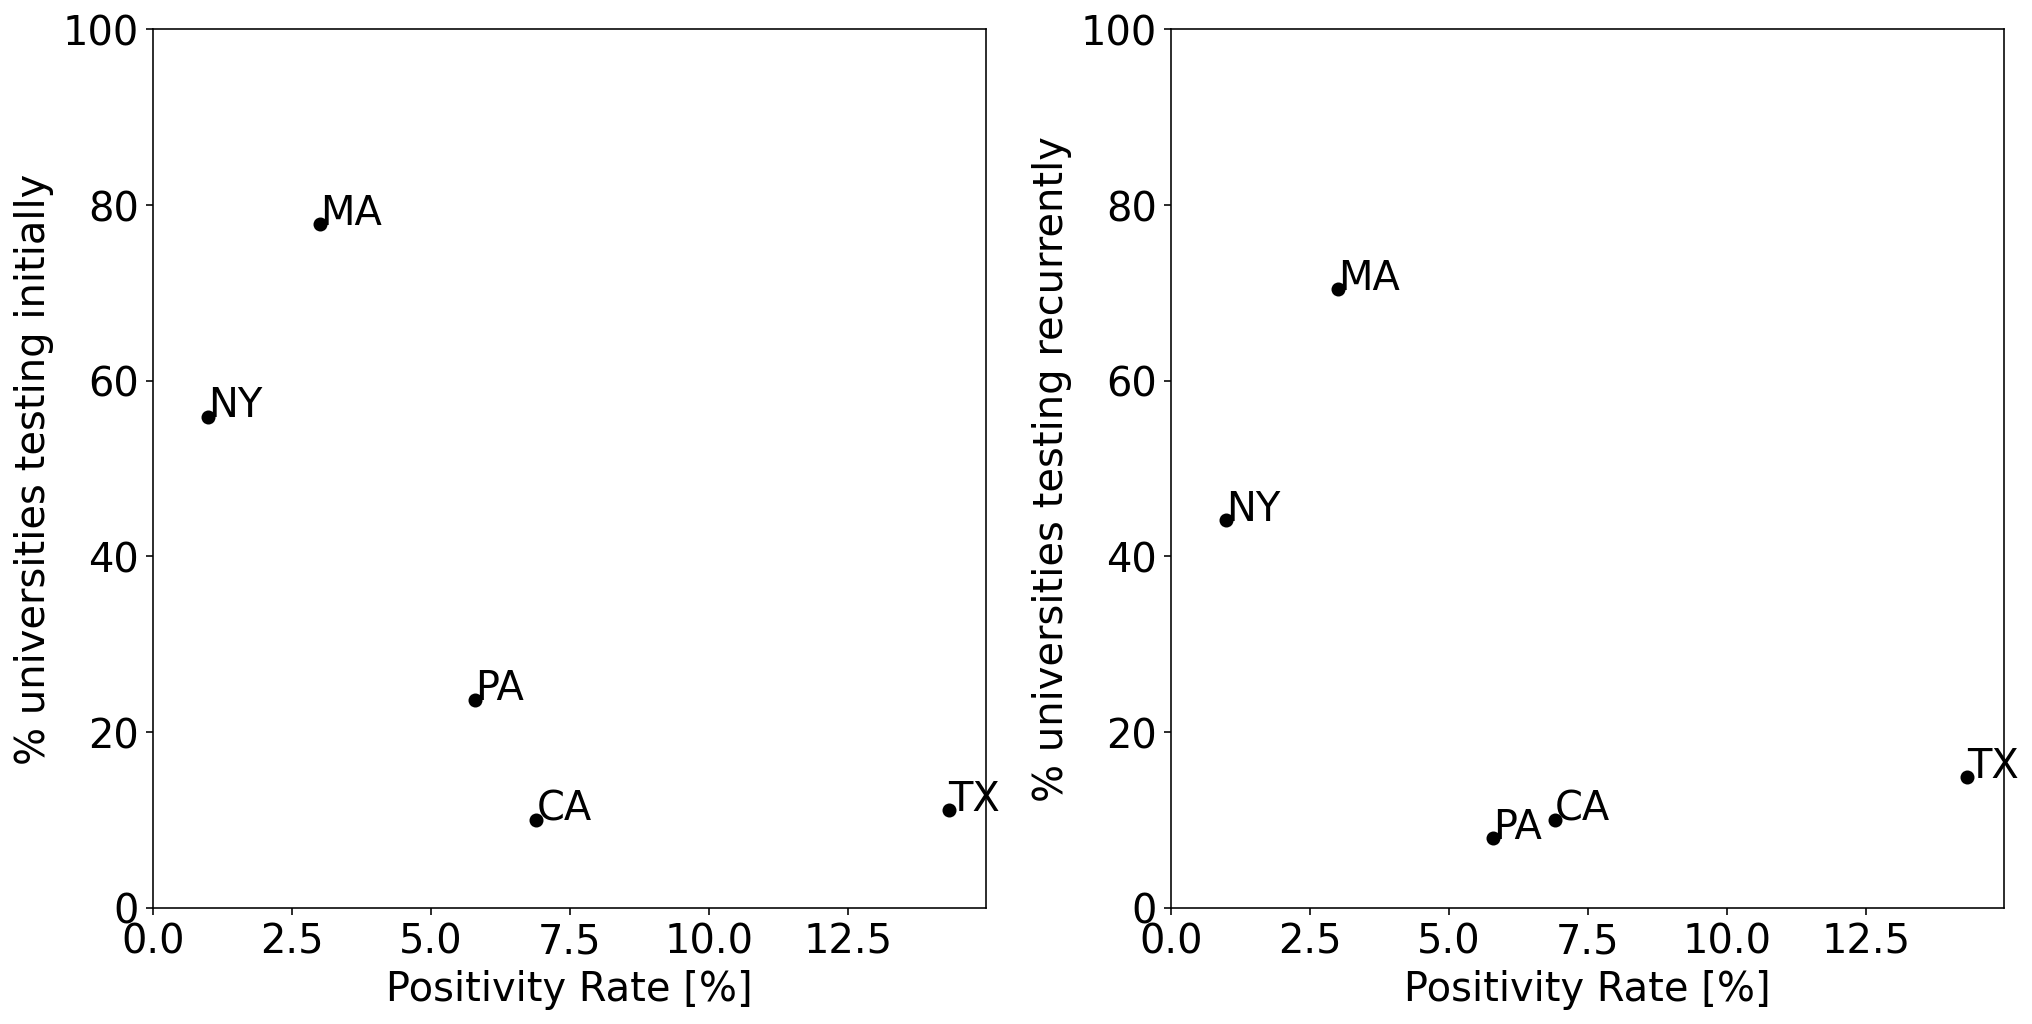

In [52]:
fig, ax = plt.subplots(figsize=(14,7), ncols=2, constrained_layout=True)

x = pos*100
y = initial.loc[top_states].TRUE.values

ax[0].scatter(x, y, color="k")

for (xx, yy, txt) in zip(x, y, top_states):
  ax[0].annotate(txt, (xx, yy))

kwd = {
    "xlabel": "Positivity Rate [%]",
    "ylabel": "% universities testing initially",
    "ylim": (0, 100),
    "xlim": (0)
}

ax[0].set(**kwd)

x = pos*100
y = recurrent.loc[top_states].TRUE.values

ax[1].scatter(x, y, color="k")

for (xx, yy, txt) in zip(x, y, top_states):
  ax[1].annotate(txt, (xx, yy))

kwd = {
    "xlabel": "Positivity Rate [%]",
    "ylabel": "% universities testing recurrently",
    "ylim": (0, 100),
    "xlim": (0)
}

ax[1].set(**kwd)

fig.show()

# US News top universities

In [53]:
usnr = pd.read_excel("http://andyreiter.com/wp-content/uploads/2019/09/US-News-Rankings-Universities-Through-2020.xlsx", header=1)

In [54]:
np.setdiff1d(usnr["University Name"], df.institution.values)

array(['College of William and Mary', 'Georgia Institute of Technology',
       'Pennsylvania State University-University Park',
       'Rutgers University-New Brunswick',
       'Texas A&M University-College Station',
       'University of California-Berkeley',
       'University of California-Davis',
       'University of California-Irvine',
       'University of California-Los Angeles',
       'University of California-San Diego',
       'University of California-Santa Barbara', 'University of Georgia',
       'University of Illinois-Urbana-Champaign',
       'University of Michigan-Ann Arbor',
       'University of North Carolina-Chapel Hill',
       'University of Texas-Austin', 'University of Wisconsin-Madison'],
      dtype=object)

In [55]:
top_map = {
  'College of William and Mary':"College of William & Mary", 
  'Georgia Institute of Technology': "University System of Georgia — Georgia Institute of Technology",
  'Pennsylvania State University-University Park': "Pennsylvania State University",
  'Rutgers University-New Brunswick': "Rutgers University",
  'Texas A&M University-College Station': "Texas A&M University system — College Station",
  'University of California-Berkeley': "University of California at Berkeley",
  'University of California-Davis':"University of California at Davis",
  'University of California-Irvine':"University of California at Irvine",
  'University of California-Los Angeles': "University of California at Los Angeles",
  'University of California-San Diego': "University of California at San Diego",
  'University of California-Santa Barbara': "University of California at Santa Barbara", 
  'University of Georgia': "University System of Georgia — University of Georgia",
  'University of Illinois-Urbana-Champaign': "University of Illinois at Urbana-Champaign",
  'University of Michigan-Ann Arbor': "University of Michigan at Ann Arbor",
  'University of North Carolina-Chapel Hill': "University of North Carolina at Chapel Hill",
  'University of Texas-Austin':"University of Texas at Austin", 
  'University of Wisconsin-Madison': "University of Wisconsin at Madison"
}

In [56]:
usnr["University Name"] = usnr["University Name"].apply(lambda x: top_map.get(x, x))

In [57]:
usnr = usnr[usnr[2020].notna()].sort_values(2020).head(50)

In [58]:
top_uni = df[df.institution.isin(usnr["University Name"].values)]

In [59]:
top_uni.shape

(50, 16)

In [60]:
top_uni.groupby(["rtc_model", "testing"]).size().unstack(fill_value=0)

testing,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,1,0
Considering a range of scenarios,0,1,0
Planning for in-person,0,8,0
Planning for online,0,5,0
Proposing a hybrid model,1,33,1


In [61]:
top_uni.query("testing=='FALSE'")

,institution,school_type,state,testing_info_link,rtc_model,last_updated,testing,testing_type,test_initial,test_recurring,test_freq,test_vendor,test_pool,Endowment,Enrollment,comments
Case Western Reserve University,Case Western Reserve University,Private,OH,https://case.edu/studentlife/healthcounseling/...,Proposing a hybrid model,7/28/2020,FALSE,No voluntary testing,FALSE,FALSE,0.0,NaN,NaN,NaN,NaN,Re-entry testing for students just announced (...


In [62]:
top_uni.groupby(["rtc_model", "test_initial"]).size().unstack(fill_value=0)

test_initial,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,1,0
Considering a range of scenarios,0,1,0
Planning for in-person,2,5,1
Planning for online,3,2,0
Proposing a hybrid model,7,25,3


In [63]:
top_uni.groupby(["rtc_model", "test_recurring"]).size().unstack(fill_value=0)

test_recurring,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,0,1
Considering a range of scenarios,0,1,0
Planning for in-person,4,3,1
Planning for online,3,2,0
Proposing a hybrid model,11,20,4


In [64]:
top_uni.groupby(["school_type", "test_initial"]).size().unstack(fill_value=0)

test_initial,FALSE,TRUE,Unknown
school_type,,,
Private,3,29,3
Public,9,5,1


In [65]:
top_uni.groupby(["school_type", "test_recurring"]).size().unstack(fill_value=0)

test_recurring,FALSE,TRUE,Unknown
school_type,,,
Private,8,22,5
Public,10,4,1


In [66]:
df[~df.institution.isin(top_uni.institution.values)].groupby(["school_type", "test_initial"]).size().unstack(fill_value=0)

test_initial,FALSE,TRUE,Unknown
school_type,,,
Private,136,70,28
Public,167,32,23


In [67]:
df[~df.institution.isin(top_uni.institution.values)].groupby(["school_type", "test_recurring"]).size().unstack(fill_value=0)

test_recurring,FALSE,TRUE,Unknown
school_type,,,
Private,145,51,38
Public,168,23,30


In [68]:
v = top_uni.groupby(['test_initial', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v

test_recurring,FALSE,TRUE,Unknown
test_initial,,,
FALSE,11,1,0
TRUE,6,25,3
Unknown,1,0,3


# Endowment and testing

In [79]:
df.head()

,institution,school_type,state,testing_info_link,rtc_model,last_updated,testing,testing_type,test_initial,test_recurring,test_freq,test_vendor,test_pool,endowment,enrollment,endowment_per_fte_enrollment,comments
Abilene Christian University,Abilene Christian University,Private,TX,https://www.acu.edu/coronavirus/july-17-2020-c...,Planning for in-person,7/22/2020,TRUE,Both asymptomatic and symptomatic,FALSE,FALSE,0.00,NaN,NaN,431945603.0,5204.0,93253.0,"Our plan includes testing any faculty, staff a..."
Academy of Art University,Academy of Art University,Private,CA,https://www.academyart.edu/academy-of-art-univ...,Proposing a hybrid model,7/27/2020,Unknown,Unknown,Unknown,Unknown,NaN,NaN,NaN,NaN,10616.0,NaN,NaN
Adelphi University,Adelphi University,Private,NY,https://www.adelphi.edu/restart/wp-content/upl...,Proposing a hybrid model,7/27/2020,TRUE,Symptomatic,TRUE,TRUE,0.33,Vault Health,NaN,188578577.0,8146.0,25374.0,"Re-entry testing of residential students, inte..."
Adrian College,Adrian College,Private,MI,http://adrian.edu/news/ac-president-docking-sa...,Planning for in-person,7/27/2020,FALSE,No voluntary testing,FALSE,FALSE,0.00,NaN,NaN,36705997.0,1856.0,22644.0,Students are required to have a negative test ...
Agnes Scott College,Agnes Scott College,Private,GA,https://www.agnesscott.edu/coronavirus/updates...,Planning for in-person,7/22/2020,TRUE,Unknown,TRUE,Unknown,0.00,Unknown,NaN,229425820.0,1030.0,240488.0,"Athletes will be tested upon arrival, students..."


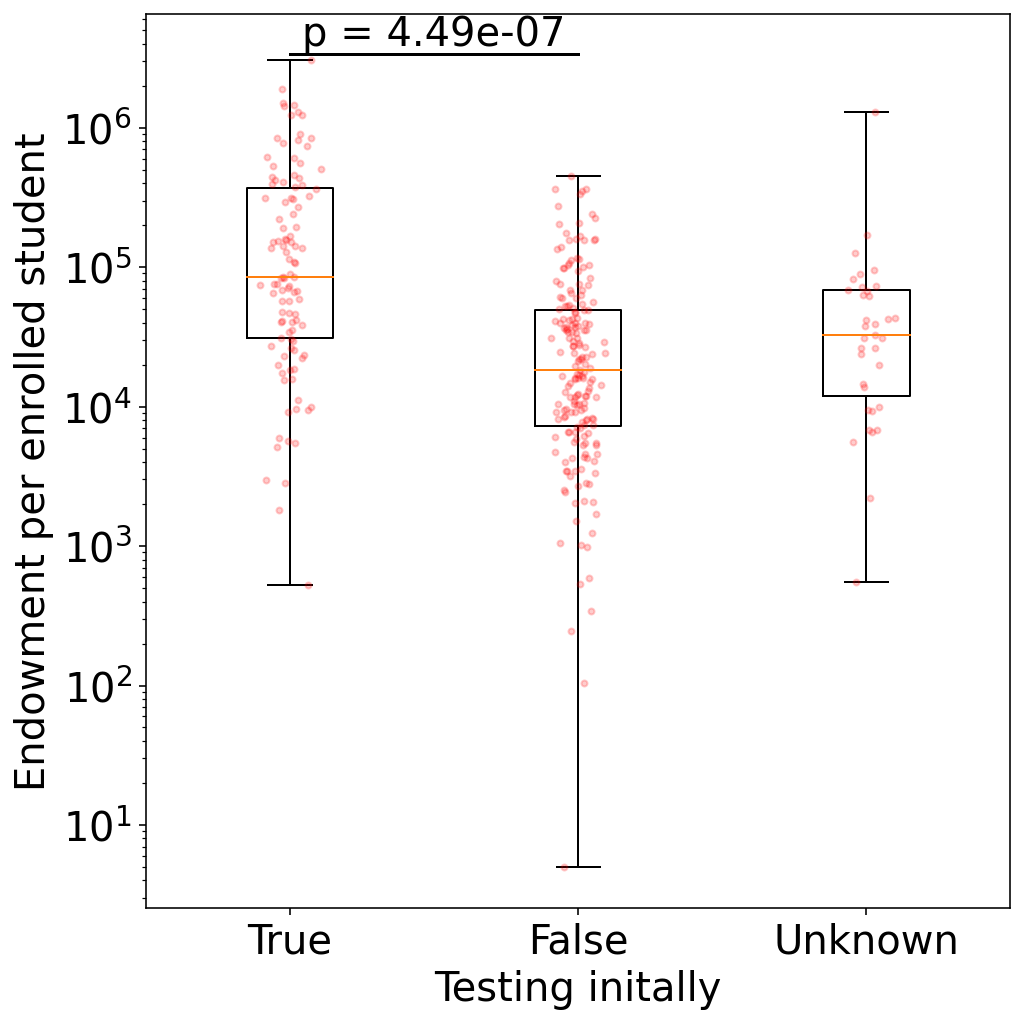

In [131]:
v = df[df["endowment_per_fte_enrollment"].notnull()].groupby("test_initial")["endowment_per_fte_enrollment"].apply(list)
f, t, u = v
tval, pval = stats.ttest_ind(t, f, equal_var=False)

fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)

labels = ["True", "False", "Unknown"]

data = [t, f, u]
ax.boxplot(data, whis=(0, 100))

for i in range(len(data)):
    y = data[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    ax.plot(x, y, 'r.', alpha=0.2)

# statistical annotation
x1, x2 = 1, 2   
yy, h, col = max(t)*(1+0.1), 0, 'k'
ax.plot([x1, x1, x2, x2], [yy, yy+h, yy+h, yy], lw=1.5, c=col)
ax.text((x1+x2)*.5, yy+h, f"p = {pval:,.2e}", ha='center', va='bottom', color=col)

kwd = {
    "xlabel" : "Testing initally",
    "ylabel": "Endowment per enrolled student",
    "yscale": "log",
    "xticklabels":labels
}
ax.set(**kwd)

fig.show()

In [129]:
len(t), len(f)

(107, 191)

In [118]:
p

4.491471018861199e-07

In [119]:
v.index

Index(['FALSE', 'TRUE', 'Unknown'], dtype='object', name='test_initial')

# Scraping college case data from the NYT

In [ ]:
from bs4 import BeautifulSoup 

In [ ]:
with open("/content/COVID-19-testing-database/data/nyt.txt", "r", encoding='utf-8') as f:
    text = f.read()

In [ ]:
s = BeautifulSoup(text)

In [ ]:
schoolname = []
schoolcases = []
schoolloc = []

sn = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolname"})
sc = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolcases"})
sl = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolloc"})
for (n, c, l) in zip(sn, sc, sl):
  name = n.text.strip()
  casenum = int(c.text.strip())
  loc = l.text.strip()
  if "*" in name:
    name = name.replace("*", "")
  if "," in name:
    name = name.replace(",", " at")
    print(name)
  schoolname.append(name)
  schoolcases.append(casenum)
  schoolloc.append(loc)

In [ ]:
cases = pd.DataFrame({"institution": schoolname, "cases":schoolcases, "location":schoolloc})
cases.index = cases["institution"].values

In [ ]:
np.intersect1d(top_uni.institution.values, cases.institution.values).shape

In [ ]:
np.setdiff1d(top_uni.institution.values, cases.institution.values)

In [ ]:
cases

In [ ]:
cases[cases.institution.str.contains("Mass")]

In [ ]:
top_uni["cases"] = top_uni.institution.map(cases["cases"])

In [ ]:
top_uni[top_uni["cases"].notna()].groupby("test_initial")["cases"].sum()

In [ ]:
top_uni[top_uni["cases"].notna()].groupby("test_recurring")["cases"].sum()